In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from tqdm import tqdm

import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_data(size, scheme, seed, a=5.0, b1=7.0, b2=14.0, c1=0.0, c2=5):
    """
    Generates data that serves as input to the function.
    Args:
        size: (int) the total number of data points
        scheme: (str) the nature of the generated data
        seed: (int) the number used to initialize random number generation
        a: (float) constant parameter
        b1: (float) time-varying parameter
        b2: (float) time-varying parameter

    Returns:
        (torch.tensor) values for a
        (torch.tensor) values for b
    """

    A = [torch.tensor(a) for i in range(size)]
    B = [b1 for i in range(size)]
    C = [c1 for i in range(size)]
    if scheme == "step":
        B = [b1 if i < size/2 else b2 for i in range(size)]
    elif scheme == "random":
        random.seed(seed)
        B = [float(random.uniform(b1, b2)) for i in range(size)]
    elif scheme == "alternate":
        B = [b1 if i % 2 == 0 else b2 for i in range(size)]
    elif scheme == "shift":
        C = [c1 if i < size / 2 else c2 for i in range(size)]
    elif scheme == "random_shift":
        random.seed(seed)
        B = [float(random.uniform(b1, b2)) for i in range(size)]
        C = [c1 if i < size / 2 else c2 for i in range(size)]

    return torch.tensor(np.array(A)), torch.tensor(np.array(B)), torch.tensor(np.array(C))

In [3]:
def cost(a, b, c, x):
    """
    the cost function
    Args:
        a, b, c: (torch.tensor) the parameters
        x: (torch.Parameter) the variable
    """

    return torch.log(a) + torch.log(torch.exp(-b * (x-c)) + torch.exp(b * (x-c)))

In [4]:
def optimize_cost_ht(gamma, n_iters, x0, a, b, c_vec, mu=1):
    """
    optimizers the cost using higher order tuner
    """
    loss_values = []
    x_values = []
    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    y = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    z = torch.tensor(x0, dtype=torch.float, requires_grad=True)

    beta = 1 / gamma
    for i in tqdm(range(n_iters)):
        N_t = b ** 2
        alpha = mu / N_t
        eta = gamma / N_t

        loss = cost(a, b, c_vec[i], x)
        loss_values.append(loss.item())
        loss.backward()
        with torch.no_grad():
            y = x - alpha * x.grad
            z = z - eta * x.grad
            x.data = beta * z + (1 - beta) * y

        x_values.append(x.item())
        x.grad = None

    loss = cost(a, b, c_vec[i], x)
    loss_values.append(loss.item())
    x_values.append(x.item())

    return loss_values, x_values

def optimize_cost(n_iters, lr, x0, optimizer_name, a_vec, b_vec, c_vec,
                  decay=False, normalize=False):
    """
    optimizes the cost function
    """

    loss_values = []
    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    x_values = [x.item()]
    optimizer = optim.Adagrad([x], lr=lr)
    
    if optimizer_name == "Adam":
        optimizer = optim.Adam([x], lr=lr)
    elif optimizer_name == "GD":
        optimizer = optim.SGD([x], lr=lr)
    for i in tqdm(range(n_iters)):
        if optimizer_name == "Adam":
            if i >= 1:
                optimizer.param_groups[0]['lr']=lr/np.sqrt(i)
        if decay:
            if i >= 1:
                optimizer.param_groups[0]['lr']=lr/np.sqrt(i)
        if normalize:
            optimizer.param_groups[0]['lr']=lr / (b_vec[i] ** 2)

        optimizer.zero_grad()
        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
        x_values.append(optimizer.param_groups[0]['params'][0].item())
        
    loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
    loss_values.append(loss.item())
    x_values.append(x.item())

    return np.array(loss_values) #, np.array(x_values)

def optimize_cost_NAGD(n_iters, x0, a_vec, b_vec, c_vec, mu=1, gamma=1,
                       normalize=False):
    """
    optimizes the function using Nesterov's Accelerated Gradient Descent
    """

    loss_values = []
    x_values = []
    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    y = torch.tensor(x0, dtype=torch.float)
    ## this corresponds to tilde z
    z = torch.tensor(x0, dtype=torch.float) * 2

    for i in tqdm(range(n_iters)):
        N_t = 1
        gamma = i / 2
        if normalize:
            N_t = b_vec[i] ** 2
            eta = gamma / N_t
        else:
            # assuming we are provided with normalized rate
            eta = gamma * mu
        alpha = mu / N_t

        beta = 2 / (i + 1)
        beta_next = 2 / (i + 2)
        x = z + (1 - beta) * y
        x.requires_grad = True
        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        loss_values.append(loss.item())
        loss.backward()
        with torch.no_grad():
            y = x - alpha * x.grad.data
            z = beta_next / beta * z - beta_next * eta * x.grad.data

        x_values.append(x.item())
        x.grad = None
    
    loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
    loss_values.append(loss.item())
    x_values.append(x.item())
        
    return np.array(loss_values)

def optimize_cost_NAGD_beck(n_iters, x0, a_vec, b_vec, c_vec, mu=1,
                            normalize=False):
    """
    implements NAGD version by Beck and Tebouille
    """

    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    y = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    loss_values = []
    x_values = [x.item()]

    lambda_prev = 0
    for i in tqdm(range(n_iters)):
        lambda_s = (1 + np.sqrt(1 + 4 * (lambda_prev ** 2))) / 2
        lambda_next = (1 + np.sqrt(1 + 4 * (lambda_s ** 2))) / 2
        gamma_s = (1 - lambda_s) / lambda_next

        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        loss_values.append(loss.item())
        loss.backward()
        N_t = 1
        if normalize:
            N_t = b_vec[i] ** 2
        alpha = mu / N_t
        with torch.no_grad():
            y_new = x - alpha * x.grad.data
            x = (1 - gamma_s) * y_new + gamma_s * y
            y = y_new

        x_values.append(x.item())
        x.requires_grad = True
        x.grad = None
        lambda_prev = lambda_s
        
    loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
    loss_values.append(loss.item())
    x_values.append(x.item())

    return loss_values #, x_values



100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6108.80it/s]


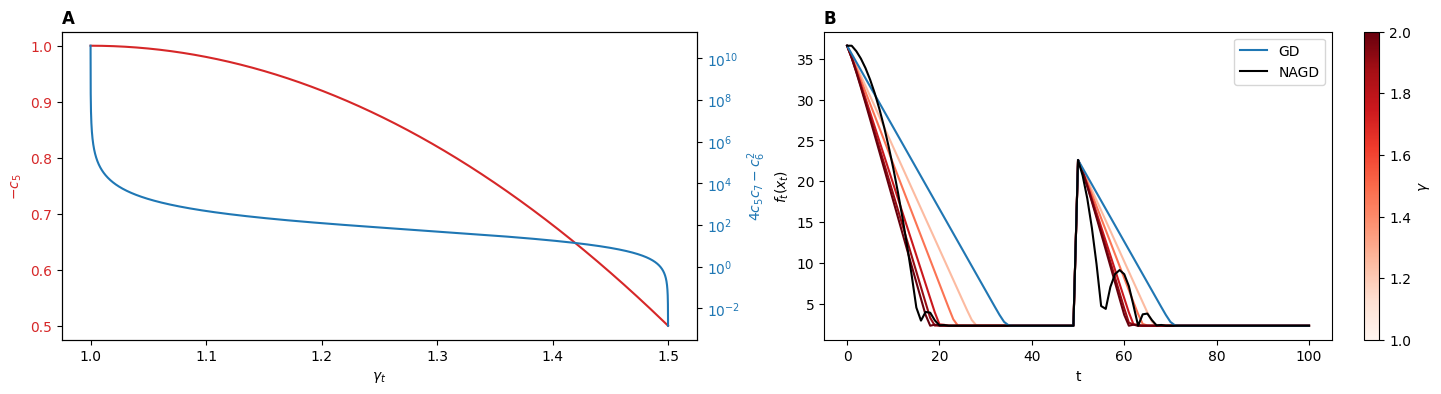

In [11]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

g = np.arange(1, 1.5, 0.00001)
b = 1 / g
m = 1
l = 1
x = 1

c5 = g**2 + x * (g-m)**2 - (1+l) * g
c6 = 2 * (x *(g-m)+g)
c7 = x - x * (1-b) ** (-2)

c8 = 4 * c5 * c7- c6**2

color = 'tab:red'
ax1.set_xlabel('$\gamma_t$')
ax1.set_ylabel('$-c_5$', color=color)
ax1.plot(g, -c5, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1_twin = ax1.twinx()

color = 'tab:blue'
ax1_twin.set_ylabel('$4c_5c_7-c_6^2$', color=color)
ax1_twin.plot(g, c8, color=color)
ax1_twin.tick_params(axis='y', labelcolor=color)
ax1_twin.set_yscale('log')
ax1.set_title("A", loc="left", fontweight="bold")

data_a, data_b, data_c = generate_data(100, "shift", 11, a=5.0, b1=7.0, b2=14.0,
                                       c2=3.0)
gamma_values = [1, 1.25, 1.47, 1.75, 1.9, 2.0]
dict_results = {}
for gamma in gamma_values:
    loss, x = optimize_cost_ht(gamma, data_a.shape[0], 5.0, torch.tensor(5.0),
                               torch.tensor(7.0), data_c)
    dict_results[gamma] = loss
    
results_gd = optimize_cost(data_a.shape[0], 1, 5.0, "GD", data_a, data_b, data_c,
                  decay=False, normalize=True)
results_nagd = optimize_cost_NAGD(data_a.shape[0], 5.0, data_a, data_b, data_c, mu=1, 
                                  gamma=1/0.67,normalize=True)
results_nagd_beck = optimize_cost_NAGD(data_a.shape[0], 5.0, data_a,data_b, data_c, 
                                            mu=1,normalize=True)

x = np.arange(0, 101)
norm = Normalize(vmin=min(dict_results.keys()), vmax=max(dict_results.keys()))
cmap = plt.get_cmap('Reds')

for key in dict_results:
    color = cmap(norm(key))
    ax2.plot(x, dict_results[key], color=color)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2)
cbar.set_label(r'$\gamma$')

#ax2.legend(title="HT($\gamma_t$)")
ax2.set_xlabel("t")
ax2.set_ylabel(r"$f_t(x_t)$")
ax2.set_title("B", loc="left", fontweight="bold")
ax2.plot(x, results_gd, color="tab:blue", label="GD")
ax2.plot(x, results_nagd_beck, color="black", label="NAGD")
ax2.legend()
plt.subplots_adjust(right=1.2)
